In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans, MiniBatchKMeans
import fs

# RANSAC #

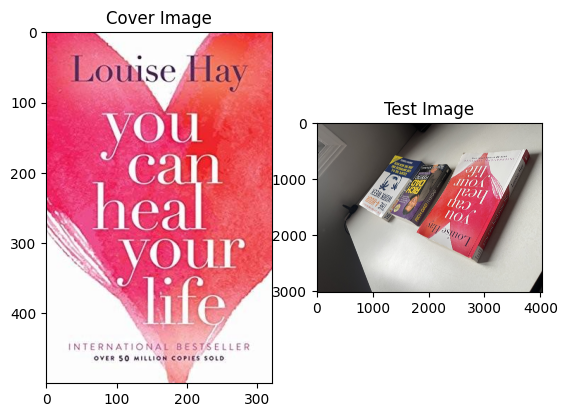

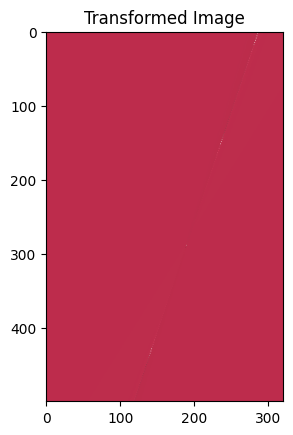

In [14]:
def extract_feature(image: np.ndarray):
    sift = cv2.SIFT_create()
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    keypoints, descriptors = sift.detectAndCompute(image, None)

    return keypoints, descriptors


def match_features(descriptors1: np.ndarray, descriptors2: np.ndarray, threshold: float = 0.8):
    """ Matches the features using the ratio of euclidean distance between the closest and second closest keypoint
    """
    matches = []
    for i in range(descriptors1.shape[0]):
        distances = np.linalg.norm(descriptors2 - descriptors1[i], axis=1)
        closest, second_closest = np.argsort(distances)[:2]
        ratio = distances[closest] / distances[second_closest]
        if ratio < threshold:
            matches.append((i, closest, distances[closest]))
    return np.array(matches)


def homography_transform(src_pts: np.ndarray, dest_pts: np.ndarray):
    homography_matrix = np.zeros((2*len(src_pts), 9))
    for i in range(len(src_pts)):
        x, y = src_pts[i]
        x_dash, y_dash = dest_pts[i]
        homography_matrix[2*i] = [x, y, 1, 0, 0, 0, -x_dash*x, -x_dash*y, -x_dash]
        homography_matrix[2*i+1] = [0, 0, 0, x, y, 1, -y_dash*x, -y_dash*y, -y_dash]

    eigen_value, eigen_vectors = np.linalg.eig(homography_matrix.T @ homography_matrix)
    min_eigen_val_index = np.argmin(eigen_value)
    return eigen_vectors[:, min_eigen_val_index].reshape(3,3)

def ransac(image_1_keypoints, image_2_keypoints, matches, iterations=100, threshold=0.5):
    best_inliers = 0
    best_homography = None
    for _ in range(iterations):
        random_indices = np.random.choice(len(matches), 4)
        src_points = []
        dest_points = []
        for i in random_indices:
            src_points.append(image_1_keypoints[int(matches[i][0])].pt)
            dest_points.append(image_2_keypoints[int(matches[i][1])].pt)

        src_points = np.float32(src_points)
        dest_points = np.float32(dest_points)

        homography_matrix = homography_transform(src_points, dest_points)

        inliers = 0
        for i, j, _ in matches:
            src_point = image_1_keypoints[int(i)].pt
            dest_point = image_2_keypoints[int(j)].pt

            src_point = np.float32([src_point[0], src_point[1], 1])
            dest_point = np.float32([dest_point[0], dest_point[1], 1])

            transformed_point = homography_matrix @ src_point
            transformed_point /= transformed_point[2]

            dist = np.linalg.norm(transformed_point[:2] - dest_point[:2])
            if dist < threshold:
                inliers += 1

        if inliers > best_inliers:
            best_inliers = inliers
            best_homography = homography_matrix
    return best_homography


cover_image = plt.imread('./project4/all_images/my_you_can_heal_your_life_100.jpg')
test_image = plt.imread('./project4/test_images/6.jpg')

image_1_keypoints, image_1_descriptors = extract_feature(cover_image)
test_image_keypoints, test_image_descriptors = extract_feature(test_image)

matches = match_features(image_1_descriptors, test_image_descriptors)
homography_matrix = ransac(image_1_keypoints, test_image_keypoints, matches, iterations=1000, threshold=0.5)

h, w, _ = cover_image.shape
transformed_image = cv2.warpPerspective(test_image, np.linalg.inv(homography_matrix), (w, h))


f, axarr = plt.subplots(1, 2)
axarr[0].imshow(cover_image)
axarr[0].set_title("Cover Image")
axarr[1].imshow(test_image)
axarr[1].set_title("Test Image")
plt.show()

plt.imshow(transformed_image)
plt.title("Transformed Image")
plt.show()

In [4]:
class VocabularyTree:
    def __init__(self, k: int=5, depth: int=5):
        self.k = k
        self.depth = depth
        self.tree = {}
        self._all_nodes = {}
        self.db_vector = []
        self.db_vector_index = []

    def build(self, descriptors: list):
        self.tree = self._build_tree(descriptors, depth=0)

    def _build_tree(self, descriptors: list, depth: int):
        if depth == self.depth:
            return {'descriptors': descriptors}
        
        if len(descriptors) < self.k:
            return None
        else:
            kmeans = KMeans(self.k)
            kmeans.fit(descriptors)
            centroids = kmeans.cluster_centers_

            tree = {}
            for i, centroid in enumerate(centroids):
                selected = kmeans.labels_ == i
                tree[i] = {'child': self._build_tree(descriptors[selected], depth + 1) if np.sum(selected) > 0 else {},
                            'centroid': centroid,
                            'mask': selected,
                            'weight': np.log(len(descriptors) / np.sum(selected)),
                            'db_passage': {},
                            'query_passage': 0
                            }
                self._all_nodes[(i, depth)] = tree[i]
            return tree
    
    def index_db(self, all_images: list[str]):
        for image_name in all_images:
            image_id = int(image_name[image_name.rfind('_')+1:image_name.rfind('.')])
            image = plt.imread(image_name)
            _, descriptors = extract_feature(image)
            self.index_db_helper(image_id, descriptors)

    def index_db_helper(self, image_id: int, descriptors: list):
        for descriptor in descriptors:
            node = self.tree
            while node.get('descriptors', None) is None:
                centroids = [node[i]['centroid'] for i in node]
                distances = np.linalg.norm(np.array(centroids) - descriptor, axis=1)
                closest = np.argmin(distances)
                node[closest]['db_passage'].setdefault(image_id, 0)
                node[closest]['db_passage'][image_id] += 1
                node = node[closest]['child']

    def calculate_vectors(self, all_images: list[str]):
        for image_name in all_images:
            image_id = int(image_name[image_name.rfind('_')+1:image_name.rfind('.')])
            self.db_vector.append(self.calculate_vectors_helper(image_id, is_db_vector=True))
            self.db_vector_index.append(image_name)
        self.db_vector = np.array(self.db_vector)

    def calculate_vectors_helper(self, image_id: int | None = None, is_db_vector: bool = True):
        vector = []
        for tree in self._all_nodes.values():
            if is_db_vector:
                tf = tree['db_passage'].get(image_id, 0)
            else:
                tf = tree['query_passage']
            idf = tree['weight']
            tf_idf = tf * idf
            vector.append(tf_idf)
        return np.array(vector)

    def query(self, descriptors: list):
        for descriptor in descriptors:
            node = self.tree
            while node.get('descriptors', None) is None:
                centroids = [node[i]['centroid'] for i in node]
                distances = np.linalg.norm(np.array(centroids) - descriptor, axis=1)
                closest = np.argmin(distances)
                node[closest].setdefault('query_passage', 0)
                node[closest]['query_passage'] += 1
                node = node[closest]['child']

        query_vector = self.calculate_vectors_helper(is_db_vector=False)
        for node in self._all_nodes.values():
            node['query_passage'] = 0
        
        scores = []
        for image, db_vector in zip(self.db_vector_index, self.db_vector):
            score = np.linalg.norm((query_vector/np.linalg.norm(query_vector, ord=1)) - (db_vector/np.linalg.norm(db_vector, ord=1)), ord=1)
            scores.append((image, score))
        scores.sort(key=lambda x: x[1])
        return scores[:10]

In [8]:
all_images = [f"./project4/all_images/{file_name}" for file_name in sorted(fs.open_fs('./project4/all_images').listdir(''))]

all_descriptors = []
all_images = all_images[90:]
for image in all_images:
    image = cv2.imread(image)
    _, descriptors = extract_feature(image)
    all_descriptors.append(descriptors)

vocab_tree = VocabularyTree(k=4, depth=3)
# build the tree
vocab_tree.build(np.concatenate(all_descriptors))

# index the database
vocab_tree.index_db(all_images)

# calculate the db_vectors for all the db images
vocab_tree.calculate_vectors(all_images)

./project4/all_images/cover_91.jpg
./project4/all_images/cover_92.jpg
./project4/all_images/my_19th_century_photo_93.jpg
./project4/all_images/my_encyclopedia_of_fire_94.jpg
./project4/all_images/my_high_definition_104.jpg
./project4/all_images/my_mafia_life_95.jpg
./project4/all_images/my_napoleonic_friendship_96.jpg
./project4/all_images/my_organizational_communication_103.jpg
./project4/all_images/my_race_and_retail_101.jpg
./project4/all_images/my_ricd_dad_poor_dad_97.jpg
./project4/all_images/my_the_4_hour_work_week_98.jpg
./project4/all_images/my_weapons_of_mass_destru_99.jpg
./project4/all_images/my_women_making_time_102.jpg
./project4/all_images/my_you_can_heal_your_life_100.jpg


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.1

# Q5 localize all the books by matching them with the books from the large database for one test image #

Top 10 matches: [('./project4/all_images/my_race_and_retail_101.jpg', 0.12285857091703424), ('./project4/all_images/cover_91.jpg', 0.14451011766812052), ('./project4/all_images/my_weapons_of_mass_destru_99.jpg', 0.14819062651271886), ('./project4/all_images/my_ricd_dad_poor_dad_97.jpg', 0.1913109759376736), ('./project4/all_images/my_women_making_time_102.jpg', 0.1943948075989825), ('./project4/all_images/cover_92.jpg', 0.21040488072866612), ('./project4/all_images/my_encyclopedia_of_fire_94.jpg', 0.29186100910248547), ('./project4/all_images/my_19th_century_photo_93.jpg', 0.319717117208457), ('./project4/all_images/my_you_can_heal_your_life_100.jpg', 0.3291151230529765), ('./project4/all_images/my_the_4_hour_work_week_98.jpg', 0.378167403457363)]


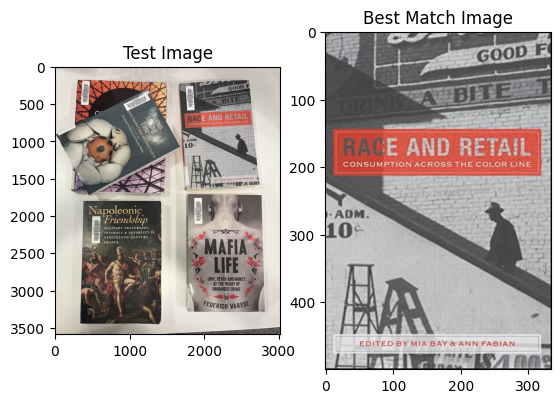

In [9]:
test_image = cv2.imread('./project4/test_images/7.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
_, descriptors = extract_feature(test_image)
top_matching_covers = vocab_tree.query(descriptors)
print(f"Top 10 matches: {top_matching_covers}")
best_match = cv2.imread(top_matching_covers[0][0])
best_match = cv2.cvtColor(best_match, cv2.COLOR_BGR2RGB)

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(test_image)
axarr[0].set_title("Test Image")

axarr[1].imshow(best_match)
axarr[1].set_title("Best Match Image")
plt.show()

# Q6 Plot each test image with all the localized book covers #

Top 10 matches for ./project4/test_images/8.jpg: [('./project4/all_images/my_race_and_retail_101.jpg', 0.1312836266207839), ('./project4/all_images/my_weapons_of_mass_destru_99.jpg', 0.14024946158525073), ('./project4/all_images/cover_91.jpg', 0.15430409888412494), ('./project4/all_images/my_ricd_dad_poor_dad_97.jpg', 0.19028559020763616), ('./project4/all_images/cover_92.jpg', 0.19991219628799298), ('./project4/all_images/my_women_making_time_102.jpg', 0.2063336068213468), ('./project4/all_images/my_encyclopedia_of_fire_94.jpg', 0.3057642241517118), ('./project4/all_images/my_19th_century_photo_93.jpg', 0.3118016294293232), ('./project4/all_images/my_you_can_heal_your_life_100.jpg', 0.33879963580195593), ('./project4/all_images/my_napoleonic_friendship_96.jpg', 0.3657639822584192)]


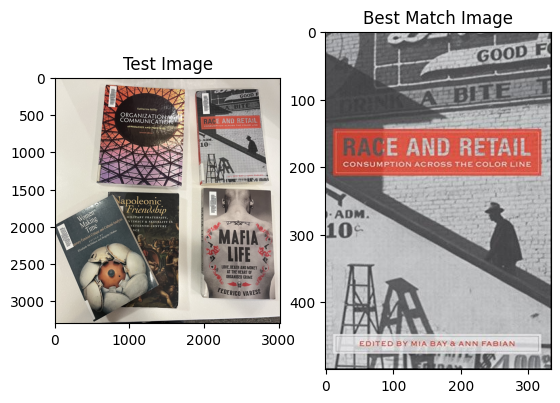

Top 10 matches for ./project4/test_images/9.jpg: [('./project4/all_images/my_race_and_retail_101.jpg', 0.12634650940465408), ('./project4/all_images/my_weapons_of_mass_destru_99.jpg', 0.20607081930617183), ('./project4/all_images/cover_91.jpg', 0.21224580317719183), ('./project4/all_images/my_encyclopedia_of_fire_94.jpg', 0.2155104505465912), ('./project4/all_images/my_women_making_time_102.jpg', 0.24391069145290145), ('./project4/all_images/my_you_can_heal_your_life_100.jpg', 0.26232892181380274), ('./project4/all_images/cover_92.jpg', 0.27802071915551363), ('./project4/all_images/my_ricd_dad_poor_dad_97.jpg', 0.289069642642519), ('./project4/all_images/my_mafia_life_95.jpg', 0.36548454175268397), ('./project4/all_images/my_19th_century_photo_93.jpg', 0.43297260171823065)]


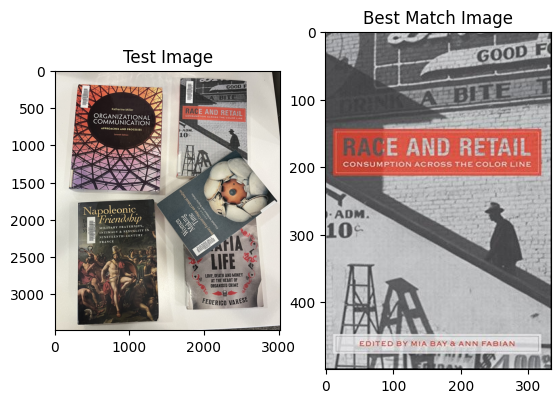

Top 10 matches for ./project4/test_images/10.jpg: [('./project4/all_images/my_race_and_retail_101.jpg', 0.131743212672409), ('./project4/all_images/my_weapons_of_mass_destru_99.jpg', 0.13588792434958852), ('./project4/all_images/cover_91.jpg', 0.16634252497714522), ('./project4/all_images/cover_92.jpg', 0.2045848238125443), ('./project4/all_images/my_ricd_dad_poor_dad_97.jpg', 0.2064175465877677), ('./project4/all_images/my_women_making_time_102.jpg', 0.21010290807519888), ('./project4/all_images/my_encyclopedia_of_fire_94.jpg', 0.28291159328744153), ('./project4/all_images/my_you_can_heal_your_life_100.jpg', 0.32623402742480156), ('./project4/all_images/my_19th_century_photo_93.jpg', 0.35032050566347933), ('./project4/all_images/my_the_4_hour_work_week_98.jpg', 0.4069474695019799)]


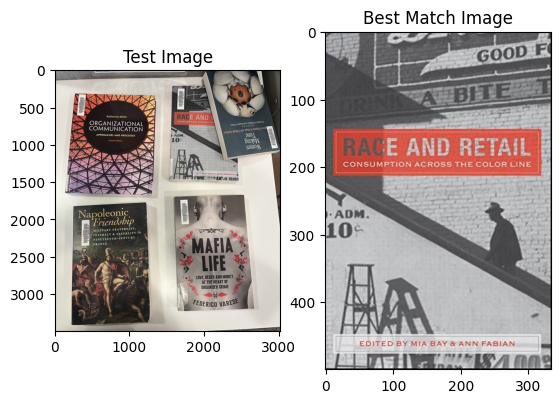

Top 10 matches for ./project4/test_images/4.jpg: [('./project4/all_images/my_napoleonic_friendship_96.jpg', 0.29188800653217495), ('./project4/all_images/my_19th_century_photo_93.jpg', 0.3288470644505125), ('./project4/all_images/my_organizational_communication_103.jpg', 0.37437295271305226), ('./project4/all_images/my_ricd_dad_poor_dad_97.jpg', 0.4000753952930504), ('./project4/all_images/cover_92.jpg', 0.4301066986359747), ('./project4/all_images/my_the_4_hour_work_week_98.jpg', 0.4560551279356345), ('./project4/all_images/my_weapons_of_mass_destru_99.jpg', 0.5009607061745649), ('./project4/all_images/my_high_definition_104.jpg', 0.5487433778946916), ('./project4/all_images/my_women_making_time_102.jpg', 0.5532877609055342), ('./project4/all_images/cover_91.jpg', 0.6188538822369298)]


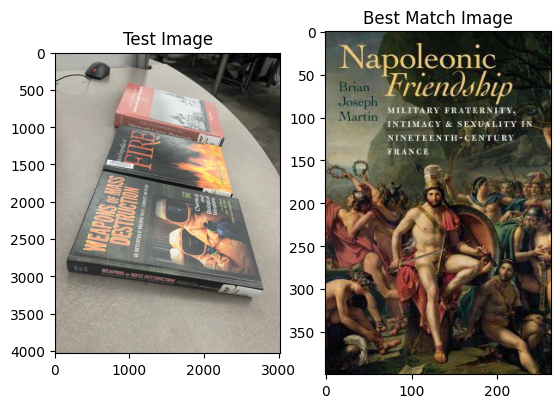

Top 10 matches for ./project4/test_images/5.jpg: [('./project4/all_images/my_napoleonic_friendship_96.jpg', 0.17956076673186253), ('./project4/all_images/my_ricd_dad_poor_dad_97.jpg', 0.21622669211439666), ('./project4/all_images/my_19th_century_photo_93.jpg', 0.22639055994871618), ('./project4/all_images/my_organizational_communication_103.jpg', 0.23146608878229147), ('./project4/all_images/my_the_4_hour_work_week_98.jpg', 0.23692453187015347), ('./project4/all_images/cover_92.jpg', 0.24345804003750998), ('./project4/all_images/my_weapons_of_mass_destru_99.jpg', 0.2729140131887703), ('./project4/all_images/my_women_making_time_102.jpg', 0.3588950879766716), ('./project4/all_images/cover_91.jpg', 0.376374334637584), ('./project4/all_images/my_high_definition_104.jpg', 0.3808147439350019)]


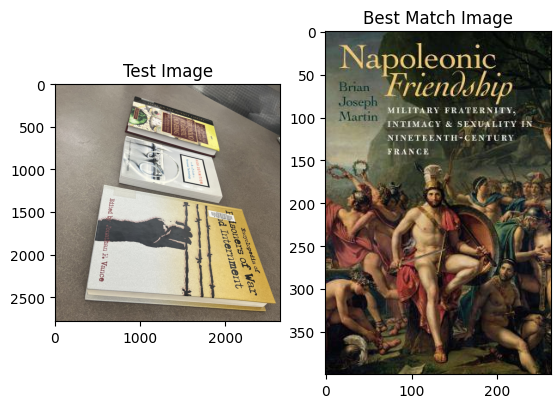

Top 10 matches for ./project4/test_images/7.jpg: [('./project4/all_images/my_race_and_retail_101.jpg', 0.12285857091703424), ('./project4/all_images/cover_91.jpg', 0.14451011766812052), ('./project4/all_images/my_weapons_of_mass_destru_99.jpg', 0.14819062651271886), ('./project4/all_images/my_ricd_dad_poor_dad_97.jpg', 0.1913109759376736), ('./project4/all_images/my_women_making_time_102.jpg', 0.1943948075989825), ('./project4/all_images/cover_92.jpg', 0.21040488072866612), ('./project4/all_images/my_encyclopedia_of_fire_94.jpg', 0.29186100910248547), ('./project4/all_images/my_19th_century_photo_93.jpg', 0.319717117208457), ('./project4/all_images/my_you_can_heal_your_life_100.jpg', 0.3291151230529765), ('./project4/all_images/my_the_4_hour_work_week_98.jpg', 0.378167403457363)]


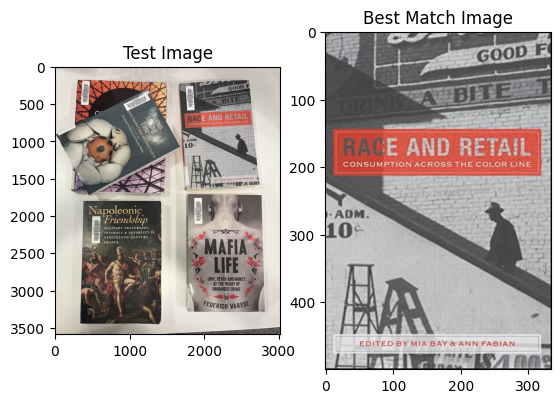

Top 10 matches for ./project4/test_images/6.jpg: [('./project4/all_images/my_race_and_retail_101.jpg', 0.15077976728813183), ('./project4/all_images/cover_91.jpg', 0.18042546187356948), ('./project4/all_images/my_women_making_time_102.jpg', 0.18456934523048776), ('./project4/all_images/my_weapons_of_mass_destru_99.jpg', 0.2192444954997842), ('./project4/all_images/my_you_can_heal_your_life_100.jpg', 0.27627386446207514), ('./project4/all_images/cover_92.jpg', 0.28704248811634414), ('./project4/all_images/my_encyclopedia_of_fire_94.jpg', 0.28718162866269215), ('./project4/all_images/my_ricd_dad_poor_dad_97.jpg', 0.30823788859826307), ('./project4/all_images/my_mafia_life_95.jpg', 0.3743711558666285), ('./project4/all_images/my_19th_century_photo_93.jpg', 0.45016854857643135)]


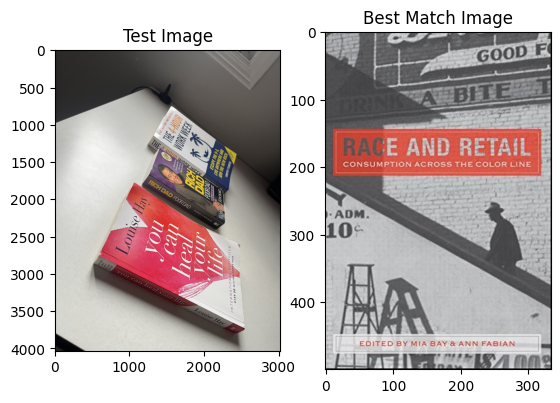

Top 10 matches for ./project4/test_images/2.jpg: [('./project4/all_images/my_encyclopedia_of_fire_94.jpg', 0.25426033017210053), ('./project4/all_images/my_race_and_retail_101.jpg', 0.2546822707039092), ('./project4/all_images/my_weapons_of_mass_destru_99.jpg', 0.2815426940934209), ('./project4/all_images/my_you_can_heal_your_life_100.jpg', 0.31143210625663903), ('./project4/all_images/cover_91.jpg', 0.3497736503027502), ('./project4/all_images/cover_92.jpg', 0.37057922911923846), ('./project4/all_images/my_women_making_time_102.jpg', 0.3751422682434764), ('./project4/all_images/my_mafia_life_95.jpg', 0.38368748515997514), ('./project4/all_images/my_ricd_dad_poor_dad_97.jpg', 0.3891775517273361), ('./project4/all_images/my_organizational_communication_103.jpg', 0.49093978886650985)]


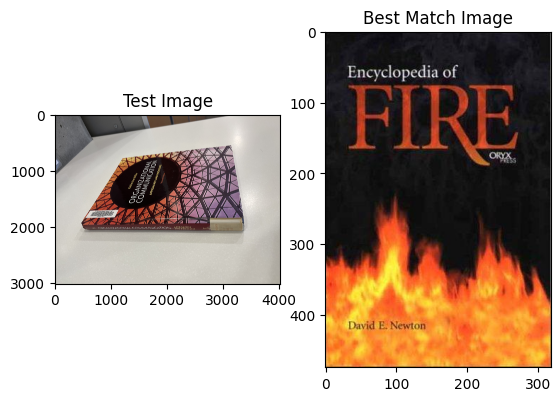

Top 10 matches for ./project4/test_images/3.jpg: [('./project4/all_images/my_race_and_retail_101.jpg', 0.21655814338525625), ('./project4/all_images/my_encyclopedia_of_fire_94.jpg', 0.24551656740940958), ('./project4/all_images/my_you_can_heal_your_life_100.jpg', 0.2562472788978448), ('./project4/all_images/my_weapons_of_mass_destru_99.jpg', 0.3439109156551228), ('./project4/all_images/cover_91.jpg', 0.3549490572715469), ('./project4/all_images/my_women_making_time_102.jpg', 0.37285434615746216), ('./project4/all_images/my_mafia_life_95.jpg', 0.3893203982456845), ('./project4/all_images/cover_92.jpg', 0.4329474506809402), ('./project4/all_images/my_ricd_dad_poor_dad_97.jpg', 0.4515457732890379), ('./project4/all_images/my_organizational_communication_103.jpg', 0.5310519518012293)]


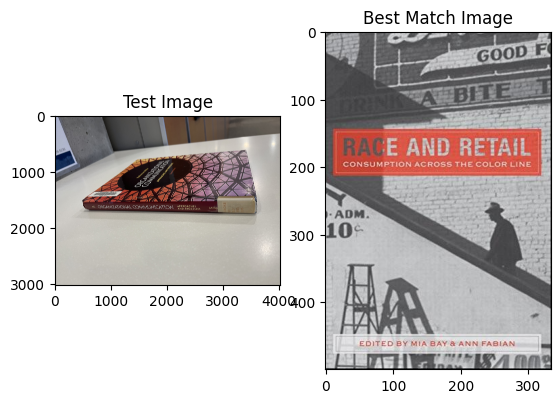

Top 10 matches for ./project4/test_images/1.jpg: [('./project4/all_images/my_encyclopedia_of_fire_94.jpg', 0.2420404086567858), ('./project4/all_images/my_race_and_retail_101.jpg', 0.2801403031179629), ('./project4/all_images/my_you_can_heal_your_life_100.jpg', 0.31379657635574354), ('./project4/all_images/my_weapons_of_mass_destru_99.jpg', 0.33078274179097683), ('./project4/all_images/my_mafia_life_95.jpg', 0.35390283849544457), ('./project4/all_images/cover_91.jpg', 0.368844276238426), ('./project4/all_images/my_women_making_time_102.jpg', 0.4013123023682123), ('./project4/all_images/cover_92.jpg', 0.4198192768167944), ('./project4/all_images/my_ricd_dad_poor_dad_97.jpg', 0.438417599424892), ('./project4/all_images/my_organizational_communication_103.jpg', 0.5199684638522846)]


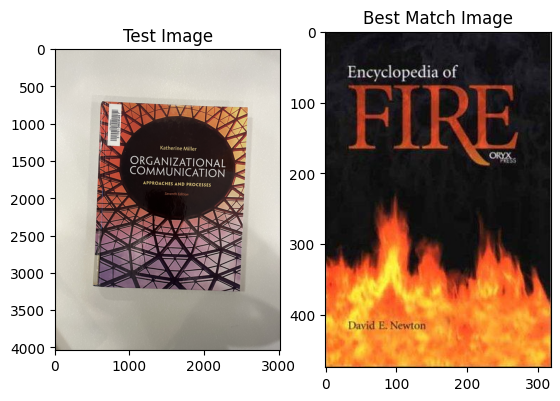

In [12]:
all_test_images = [f"./project4/test_images/{file_name}" for file_name in fs.open_fs('./project4/test_images').listdir('')]
# calculate the query vector for the query image
for image_name in all_test_images:
    test_image = cv2.imread(image_name)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    _, descriptors = extract_feature(test_image)
    top_matching_covers = vocab_tree.query(descriptors)
    best_match = cv2.imread(top_matching_covers[0][0])
    best_match = cv2.cvtColor(best_match, cv2.COLOR_BGR2RGB)

    print(f"Top 10 matches for {image_name}: {top_matching_covers}")
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(test_image)
    axarr[0].set_title("Test Image")

    axarr[1].imshow(best_match)
    axarr[1].set_title("Best Match Image")
    plt.show()
